In [1]:
# Step 1: IMPORTING THE LIBRARIES

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Time Series and Forecasting
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense ,Dropout

In [3]:
# Step 2: Load the cleaned data

In [4]:
# Load your cleaned dataset
air_aware_data= pd.read_csv("C:/Users/Dell/Downloads/Infosys classes/cleaned_air_aware_data.csv")

# Convert Date/Time column to datetime if exists
air_aware_data['Time'] = pd.to_datetime(air_aware_data['Time'], errors='coerce')

# Drop missing values
air_aware_data.dropna(inplace=True)

# Display structure
print(air_aware_data.head())

                                            City    AQI  PM2.5   PM10    O3  \
0                    Gulzarpet, Anantapur, India   88.0   88.0   71.0  26.3   
1  Anand Kala Kshetram, Rajamahendravaram, India   58.0   58.0   45.0  14.6   
2                Tirumala-APPCB, Tirupati, India  110.0  110.0   53.0  15.0   
4                  Naharlagun, Naharlagun, India   53.0   53.0   18.0   1.0   
5                    Pan Bazaar, Guwahati, India  106.0   91.0  106.0   7.1   

    NO2   SO2   CO   Latitude  Longitude                Time  
0   4.6   2.4  6.5  14.675886  77.593027 2024-05-04 18:00:00  
1  12.0   6.9  6.7  16.987287  81.736318 2024-05-04 18:00:00  
2  13.8   1.8  9.0  13.670000  79.350000 2024-05-04 18:00:00  
4   1.1   1.6  2.4  27.103358  93.679645 2024-05-04 09:00:00  
5   1.7  25.5  5.9  26.187500  91.744194 2024-05-04 18:00:00  


In [5]:
# Step 3: Convert Categorical Data → Numerical

In [6]:
# Check if there are any categorical columns
categorical = air_aware_data.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical)

# Example: Convert weather condition, location, etc., if present
air_aware_data = pd.get_dummies(air_aware_data, columns=categorical, drop_first=True)
# This converts the 'City' column into dummy/one-hot encoded columns — one column per city 
# (except one dropped to prevent multicollinearity).

Categorical columns: Index(['City'], dtype='object')


In [7]:
# Step 4: Split Data into Train & Test

In [8]:
# Predicting PM2.5 as target variable
target = 'PM2.5'

X = air_aware_data.drop(columns=[target, 'Time'])
y = air_aware_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(X_train.shape, X_test.shape)

(91, 110) (23, 110)


In [9]:
# Step 5: Choose & Train Best Algorithm

In [10]:
# (a) ARIMA Model

In [11]:
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(y_train, order=(5,1,0))
model_fit = model_arima.fit()
y_pred_arima = model_fit.forecast(steps=len(y_test)) # Get ARIMA predictions

rmse_arima = sqrt(mean_squared_error(y_test, y_pred_arima))
print("ARIMA RMSE:", rmse_arima)

C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA RMSE: 46.24882791688369


C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [12]:
# (b) Prophet Model

18:58:49 - cmdstanpy - INFO - Chain [1] start processing
18:58:50 - cmdstanpy - INFO - Chain [1] done processing


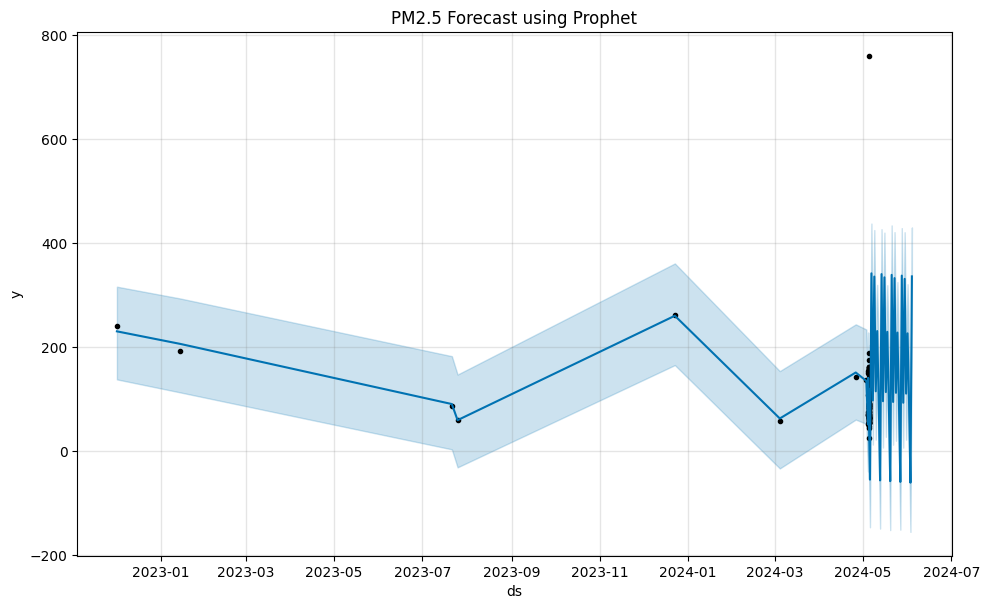

In [13]:
prophet_air_aware_data = pd.DataFrame({
    'ds': air_aware_data['Time'],
    'y': air_aware_data['PM2.5']
})

model_prophet = Prophet()
model_prophet.fit(prophet_air_aware_data)

future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)
y_pred_prophet = forecast['yhat'][-len(y_test):].values  # Get Prophet predictions

model_prophet.plot(forecast)
plt.title("PM2.5 Forecast using Prophet")
plt.show()

In [14]:
# (c) LSTM Model

In [15]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(y.values.reshape(-1,1))

train_size = int(len(scaled_data)*0.8)
train, test = scaled_data[0:train_size], scaled_data[train_size:]

X_train, y_train = [], []
for i in range(10, len(train)):
    X_train.append(train[i-10:i, 0])
    y_train.append(train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

model_lstm.fit(X_train, y_train, epochs=15, batch_size=32, verbose=1)

<IPython.core.display.Javascript object>

C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0197
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0133
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0089
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0129
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0179
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0082
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0181
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0181 
Epoch 9/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0114
Epoch 10/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0178
Epoch 11/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0117
Epoch 12/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0178
Epoch 13/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0114
Epoch 14/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0178 
Epoch 15/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0116


In [16]:
y_pred_lstm = model_lstm.predict(X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


In [17]:
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test = scaler.inverse_transform(y_test.values.reshape(-1, 1))



In [18]:
# y_test: your actual AQI (ground truth values)
# y_pred_arima: predictions from ARIMA
# y_pred_prophet: predictions from Prophet
# y_pred_lstm: predictions from LSTM

In [19]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE for each model
rmse_ARIMA = np.sqrt(mean_squared_error(y_test, y_pred_arima))
rmse_Prophet = np.sqrt(mean_squared_error(y_test, y_pred_prophet))
rmse_LSTM = np.sqrt(mean_squared_error(y_test, y_pred_lstm))

print(f"ARIMA RMSE: {rmse_ARIMA:.2f}")
print(f"Prophet RMSE: {rmse_Prophet:.2f}")
print(f"LSTM RMSE: {rmse_LSTM:.2f}")

# Compare models based on lowest RMSE
best_model = min(
    {'ARIMA': rmse_ARIMA, 'Prophet': rmse_Prophet, 'LSTM': rmse_LSTM},
    key=lambda x: {'ARIMA': rmse_ARIMA, 'Prophet': rmse_Prophet, 'LSTM': rmse_LSTM}[x]
)
print(f"Best model: {best_model}")


ARIMA RMSE: 85860.89
Prophet RMSE: 85804.75
LSTM RMSE: 85853.73
Best model: Prophet


In [20]:
# Step for training the model using LSTM

In [21]:
# Step: Feature Selection & Normalisation (scaling)
#You are picking only the columns that are relevant for prediction. LSTMs can’t handle irrelevant features well; including unnecessary columns adds noise and slows training.
# Normalisation: scale values to 0–1 so LSTM trains faster and more accurately.

In [23]:
# Select features (you can add/remove pollutants)
features = ['PM2.5', 'PM10', 'NO2', 'O3', 'SO2']

# Normalize data for neural network training
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(air_aware_data[features])

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=features)

<IPython.core.display.Javascript object>

In [24]:
#  Create Time-Series Sequences
# This function converts your continuous time series data into supervised learning samples — small sequences that LSTM can learn from.

In [25]:
def create_sequences(air_aware_data, time_steps=24):
    X, y = [], []
    for i in range(len(air_aware_data) - time_steps):
        X.append(air_aware_data[i:(i + time_steps)])
        y.append(air_aware_data[i + time_steps, 0])  # predict PM2.5
    return np.array(X), np.array(y)

time_steps = 24  # 1 day if data is hourly
# previous 24 hours to predict next hour
X, y = create_sequences(scaled_data, time_steps)


In [26]:
# Build the LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dense(16, activation='relu'),  # ReLU activation → introduces non-linearity to capture complex relationships.
    #Connects the temporal features from LSTM to the final output.
    Dense(1)  # PM2.5 prediction
])

model.compile(optimizer='adam', loss='mse')
model.summary()


C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 10, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 376ms/step - loss: 0.0195 - val_loss: 7385927680.0000
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0123 - val_loss: 7385923584.0000
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0099 - val_loss: 7385917952.0000
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0083 - val_loss: 7385911296.0000
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0183 - val_loss: 7385908736.0000
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0122 - val_loss: 7385912320.0000
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0119 - val_loss: 7385917952.0000
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0086 - val_loss: 7385920512.0000
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0187 - val_loss: 7385917952.0000
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0115 - val_loss: 7385916928.0000
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0113 - val_loss: 7

In [28]:
# Evaluate Model Performance
# Predict
predictions = model.predict(X_test)

# Inverse scale to original units
predicted_pm25 = scaler.inverse_transform(
    np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1]-1))), axis=1)
)[:, 0]

actual_pm25 = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1,1), np.zeros((y_test.shape[0], scaled_data.shape[1]-1))), axis=1)
)[:, 0]

# Evaluation metrics
mae = mean_absolute_error(actual_pm25, predicted_pm25)
rmse = np.sqrt(mean_squared_error(actual_pm25, predicted_pm25))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
MAE: 59372586.56
RMSE: 63166888.56


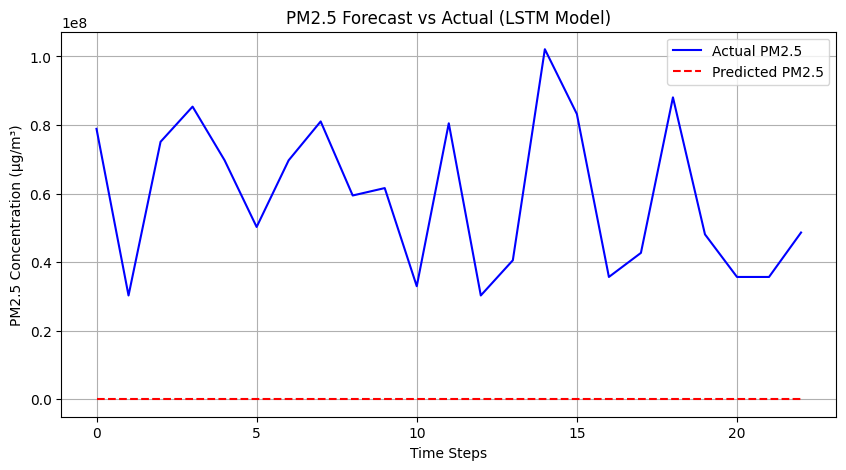

In [29]:
# Visualization
plt.figure(figsize=(10,5))
plt.plot(actual_pm25[:100], label='Actual PM2.5', color='blue')
plt.plot(predicted_pm25[:100], label='Predicted PM2.5', color='red', linestyle='--')
plt.title('PM2.5 Forecast vs Actual (LSTM Model)')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5 Concentration (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()
